# Install Needed Packages

In [1]:
# package for recording time
! pip install pendulum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 2.7 MB/s eta 0:00:00


In [2]:
# package for warmup scheduler
# https://github.com/ildoonet/pytorch-gradual-warmup-lr
! pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-l8kinjq4
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-l8kinjq4
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3865 sha256=46a9fbf7883186684c2f933b0b87a597712a8fc4342c2cdcef5e3bb2603aa8c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgjcjz3l/wheels/49/78/e6/9168d5844935482a171c7880a0626fa1c6c412b55666635f59
Successfully built warmup_scheduler


# Load Data with Image Transformation

In [3]:
# set image transformer 
import torch
import torchvision
import torchvision.transforms as transforms

transform_set = [
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(),  
    transforms.RandomRotation(20),
]

# define the transformation you want to apply to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image and resize it to 224x224
    transforms.RandomApply(transform_set, p=0.9),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

main_path = f"/kaggle/input/flowers-recognition/flowers"

# load the dataset from the three folders
dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(main_path),
    transform=transform
)

# get class idx to name map for further uses
idx2label = {idx: label for label, idx in dataset.class_to_idx.items()}

In [5]:
# Stratified Sampler

from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# split indices into train and val
indices = list(range(len(dataset)))
train_indices,val_indices = train_test_split(indices, test_size=0.3, stratify=dataset.targets) 

# create subset sampler for train and val
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# load data with sampler and batch_size
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1
)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1
)

# Data Analytics - EDA
Let's take a look at the overall data pattern for further model training

In [6]:
from collections import Counter
print(dataset.class_to_idx)
print()
print('- dataset size: ', len(dataset))
print('  class count:', dict(Counter(dataset.targets)))
print()
print('- train dataset size: ', len(train_sampler))
print('- val dataset size: ', len(val_sampler))

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

- dataset size:  4317
  class count: {0: 764, 1: 1052, 2: 784, 3: 733, 4: 984}

- train dataset size:  3021
- val dataset size:  1296


In [7]:
# Reference
# https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py

from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

def imshow_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def show_dataloader_images(data_loader):
    images, labels = next(iter(data_loader))
    images = [img for img in images]
    grid = make_grid(images)
    imshow_grid(grid)

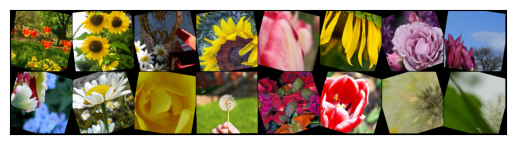

In [8]:
show_dataloader_images(train_loader)

# Train Model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
from torchvision import models
import random

# set random seeds for reproducing the result
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

set_seed()

# load the ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True).to(device)

# freeze the layers of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False

# set hyperparameter
CFG = dict(
    learning_rate = 5e-7,
    epochs = 15,
    lin1_size = 128,
    lin2_size = 128,
    activation = 'relu',
    model = 'resnet50'
)
    
# add a new classification head to the model
model.fc = nn.Sequential(
    nn.Linear(2048, CFG['lin1_size']),
    nn.ReLU(),
    nn.Linear(CFG['lin2_size'], len(dataset.classes))
).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [11]:
import torch.optim.lr_scheduler as lr_scheduler
from warmup_scheduler import GradualWarmupScheduler

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters())

# Learning rate scheduler with warmup
torch_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'])
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=1, total_epoch=CFG['epochs'], after_scheduler=torch_lr_scheduler
)

In [12]:
import pendulum as pdl
from sklearn.metrics import classification_report
import numpy as np

# reference
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_one_epoch(train_loader, model, criterion, optimizer, scheduler):
    # Train mode
    model.train()
    
    # Track metrics
    loss_epoch = 0
    accuracy_epoch = 0
    
    # Track time
    curr_time = pdl.now()
    
    # Loop over minibatches
    for inputs, labels in train_loader:
        # Send to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()

        # Update parameters
        optimizer.step()

        # Zero gradients
        optimizer.zero_grad()

        # Track loss
        loss_epoch += loss.detach().item()
        
        # Accuracy
        _, preds = torch.max(outputs, 1)
        accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]
        
    # Update learning rate
    scheduler.step()
        
    return loss_epoch/len(train_loader), accuracy_epoch.item()/len(train_loader)


def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, verbose=True):

    print('Start Training Model...')
    
    # Initialise outputs
    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    # Initiate current time
    t0 = pdl.now()
    org_time = t0
    
    # Loop over epochs
    for epoch in range(CFG['epochs']):
        # train
        train_loss, train_accuracy = train_one_epoch(train_loader, model, criterion, optimizer, scheduler)
        
        # evaluate
        val_loss, val_accuracy = evaluate_one_epoch(val_loader, model, criterion)
        
        # track metrics
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_accuracy)
        val_acc_hist.append(val_accuracy)
        
        # print loss
        if verbose:
            if (epoch+1)%1==0:
                # calculate elapsed time
                curr_time = pdl.now()
                interval = curr_time - org_time
                org_time = curr_time
                print(f'Epoch {epoch+1}/{CFG["epochs"]}, loss {train_loss:.5f}, val_loss {val_loss:.5f}, accuracy {train_accuracy:.5f}, val_accuracy {val_accuracy:.5f}, elapsed time {interval.in_minutes() % 60:02d}:{interval.in_seconds() % 60:02d}')
    
    interval = pdl.now() - t0
    print(f'Finish model training, total time cost: {interval.in_minutes() % 60:02d}:{interval.in_seconds() % 60:02d}')
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


def evaluate_one_epoch(val_loader, model, criterion):
    # eval mode
    model.eval()
    
    # track metrics
    loss_epoch = 0
    accuracy_epoch = 0
    
    # don't update weights
    with torch.no_grad():
        # loop over minibatches
        for inputs, labels in val_loader:
            # send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # track loss
            loss_epoch += loss.detach().item()
            
            # accuracy
            _, preds = torch.max(outputs, 1)
            accuracy_epoch += torch.sum(preds == labels)/inputs.shape[0]
    
    return loss_epoch/len(val_loader), accuracy_epoch.item()/len(val_loader)


# plot history
def plot_hist(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train Loss')
    plt.plot(val_loss_hist, label='Validation Loss')
    plt.title('Cross Entropy Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train Accuracy')
    plt.plot(val_acc_hist, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
# functions for checking accuracy for each class
def get_classification_report(dataloader):
    pred_list = []
    label_list = []
    for inputs, labels in dataloader:
        # send to device
        inputs = inputs.to(device)
        label_list.append(labels.cpu().numpy())
        pred_list.append(model(inputs).cpu().detach().numpy())
        
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in pred_list for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in label_list for item in sublist]

    print(classification_report(flat_predictions,flat_true_labels))

In [13]:
# Train model
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, verbose=True
)

Start Training Model...
Epoch 1/15, loss 1.63922, val_loss 1.64139, accuracy 0.16863, val_accuracy 0.16744, elapsed time 00:40
Epoch 2/15, loss 1.20493, val_loss 0.87996, accuracy 0.59336, val_accuracy 0.74383, elapsed time 00:20
Epoch 3/15, loss 0.76895, val_loss 0.58727, accuracy 0.74265, val_accuracy 0.80633, elapsed time 00:21
Epoch 4/15, loss 0.63932, val_loss 0.52866, accuracy 0.76587, val_accuracy 0.81559, elapsed time 00:20
Epoch 5/15, loss 0.58861, val_loss 0.48043, accuracy 0.78780, val_accuracy 0.82022, elapsed time 00:21
Epoch 6/15, loss 0.53752, val_loss 0.53336, accuracy 0.80433, val_accuracy 0.79784, elapsed time 00:21
Epoch 7/15, loss 0.56236, val_loss 0.45816, accuracy 0.79317, val_accuracy 0.83410, elapsed time 00:21
Epoch 8/15, loss 0.55679, val_loss 0.46383, accuracy 0.79665, val_accuracy 0.83179, elapsed time 00:21
Epoch 9/15, loss 0.58315, val_loss 0.42453, accuracy 0.79011, val_accuracy 0.84259, elapsed time 00:21
Epoch 10/15, loss 0.54157, val_loss 0.42897, accu

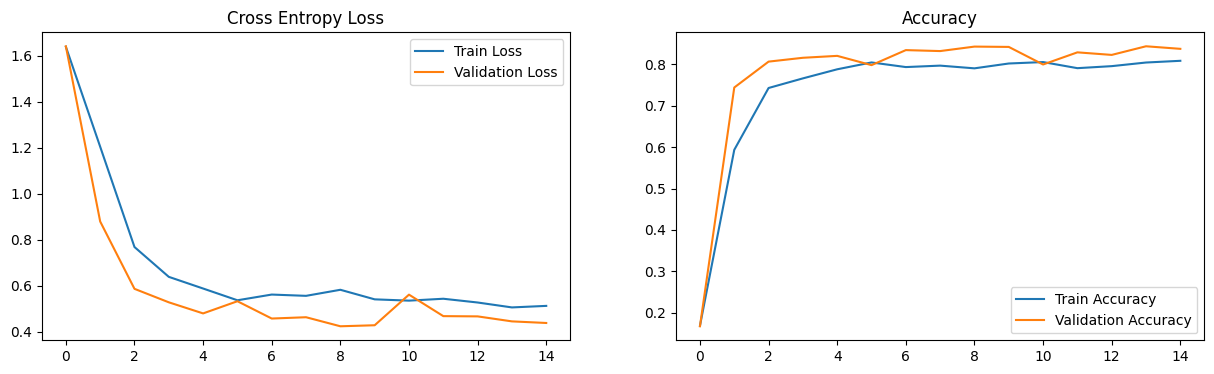

In [14]:
# plot the training history
plot_hist(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist)

In [15]:
# get performance under each class
get_classification_report(val_loader)

              precision    recall  f1-score   support

           0       0.80      0.89      0.85       206
           1       0.89      0.89      0.89       318
           2       0.74      0.85      0.79       207
           3       0.81      0.95      0.88       189
           4       0.93      0.73      0.82       376

    accuracy                           0.84      1296
   macro avg       0.84      0.86      0.84      1296
weighted avg       0.85      0.84      0.84      1296

